In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import time
import random
import glob
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.utils.data import Dataset, DataLoader, DistributedSampler
from torch.multiprocessing.spawn import spawn
import torchvision.models as models
import torchvision.datasets as dst
from torchvision.io import read_image
from torchvision.transforms import v2

In [2]:
# dataset
DATA_LOOT = "/export/data/dataset/COCO/train2014"
STYLE_IMG_PATH = "./data/NST/gohho.png"
DATA_SIZE = 128

# class CustomDataset(Dataset):
#     def __init__(self, data_root, style_img_path, img_size):
#         self.content_paths = glob.glob(os.path.join(data_root, "*.jpg"))

#         self.transforms = v2.Compose([
#             v2.Resize(img_size),
#             v2.CenterCrop(img_size),
#             v2.ToTensor(),
#             v2.Lambda(lambda x: x.mul(255)), #VGGは256スケールで学習
#             v2.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std =[0.229, 0.224, 0.225]
#             )
#         ])

#         # スタイル画像読み込み
#         style_img = read_image(style_img_path)
#         self.style_tensor = self.transforms(style_img)

#     def __len(self):
#         return len(self.content_paths)

#     def __getitem__(self, idx):
#         content_img = read_image(self.content_paths[idx])
#         content_tensor = self.transforms(content_img)
#         return content_tensor, self.style_tensor

In [3]:
imgs = glob.glob(os.path.join(DATA_LOOT, "*.jpg"))
len(imgs)

82783

### 検証

In [4]:
def preprocessing(img, img_size):
    transforms = v2.Compose([
        v2.Resize(img_size),
        v2.CenterCrop(img_size),
        v2.ToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(
            mean=[0.485, 0.456, 0.406],
            std =[0.229, 0.224, 0.225]
        )
    ])
    return transforms(img)

class TransformerNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Down-sampling
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 9, stride=1, padding=4),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
        )
        # Residual Blocks
        res_blocks = []
        for _ in range(5):
            res_blocks += [nn.Sequential(
                nn.Conv2d(128,128,3,padding=1),
                nn.InstanceNorm2d(128, affine=True),
                nn.ReLU(True),
                nn.Conv2d(128,128,3,padding=1),
                nn.InstanceNorm2d(128, affine=True),
            )]
        self.residuals = nn.Sequential(*res_blocks)
        # Up-sampling
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(128,64,3,2,1,output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,32,3,2,1,output_padding=1),
            nn.ReLU(True),
            nn.Conv2d(32,3,9,stride=1,padding=4),
            nn.Tanh(),
        )

    def forward(self, x):
        y = self.conv1(x)
        y = self.residuals(y) + y
        return (self.upsample(y) + 1) / 2  # [0,1] にスケーリング

torch.Size([3, 290, 390])


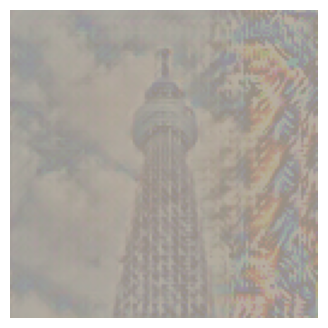

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model
model = TransformerNet().to(device)
model.load_state_dict(torch.load("8_1_rst.pth"))
model = nn.DataParallel(model)

# data
img_path = "data/NST/skytree.png"
img = read_image(img_path)[0:3,:,:]
print(img.shape)
img = preprocessing(img, img_size=128).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    styled_img = model(img)

# 可視化
def reprocessing(img):
    if img.ndim == 3:      # (C,H,W) → (1,C,H,W) に合わせる
        img = img.unsqueeze(0)
    img = (img + 1.) / 2.
    mean = torch.tensor([0.485, 0.456, 0.406], device=img.device).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=img.device).view(1,3,1,1)
    img = img * std + mean              
    return img.clamp(0,1).squeeze(0) #clamp()は念の為

vis = reprocessing(styled_img)
plt.figure(figsize=(4,4))
plt.imshow(vis.cpu().permute(1,2,0))
plt.axis('off')
plt.show()

In [11]:
vis.shape

torch.Size([3, 128, 128])